# Harringtonine CropArray Example

---

## Notebook summary 


- Load a microscope image of video
- Tracking spots on the image and generate a pandas dataframe with the spots locations
- Creating a croparray with the image and dataframe
- Signal quantification and plotting
- Visualization of croparray with Napari

----

## Importing libraries


----

In [1]:
# To manipulate arrays
import numpy as np 
from skimage.io import imread
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  
import pathlib # for working with windows paths
import sys
import cv2
import trackpy as tp
#!pip install shapely
from shapely.geometry import Polygon 
from shapely.geometry import Point
current_dir = pathlib.Path().absolute()
croparray_dir = current_dir.parents[0].joinpath('croparray')
sys.path.append(str(croparray_dir))
import crop_array_tools as ca
# %matplotlib inline 
plt.style.use('dark_background')

In [2]:
# Napari 
%gui qt5 
import napari
from napari.utils import nbscreenshot

## Parameters for quantification


----

In [20]:
# Data filename and directory
dir = r'X:\Tim'
dir = r'Z:\galindo\1_Imaging_Data\20220210_metabolites\PEP_10mM'
#img_4D_max_filename = r'MAX_Chamber02_HT_Cell01.tif'
img_4D_filename = r'Chamber02_HT_Cell02.tif'
img_4D_filename = r'Cell02.tif'

## Loading data


----

In [21]:
# Video directory
img_file_path = os.path.join(dir,img_4D_filename)  
#img_4D_max = imread(os.path.join(dir,img_4D_max_filename))
img_4D =  imread(os.path.join(dir,img_4D_filename))

In [22]:
img_4D.shape

(65, 13, 512, 512, 3)

In [23]:
# Converting the video to Croparray format
img_croparray = np.expand_dims(img_4D,axis=0) # expanding to include fov
#img_croparray = np.expand_dims(img_croparray,axis=5) # may need to do this if original movie was a single-channel movie
img_croparray.shape # dimensions MUST be (fov, f , z, y, x, ch)
img_croparray.shape

print("croparray format shape [fov, f , z, y, x, ch] = ", img_croparray.shape)

croparray format shape [fov, f , z, y, x, ch] =  (1, 65, 13, 512, 512, 3)


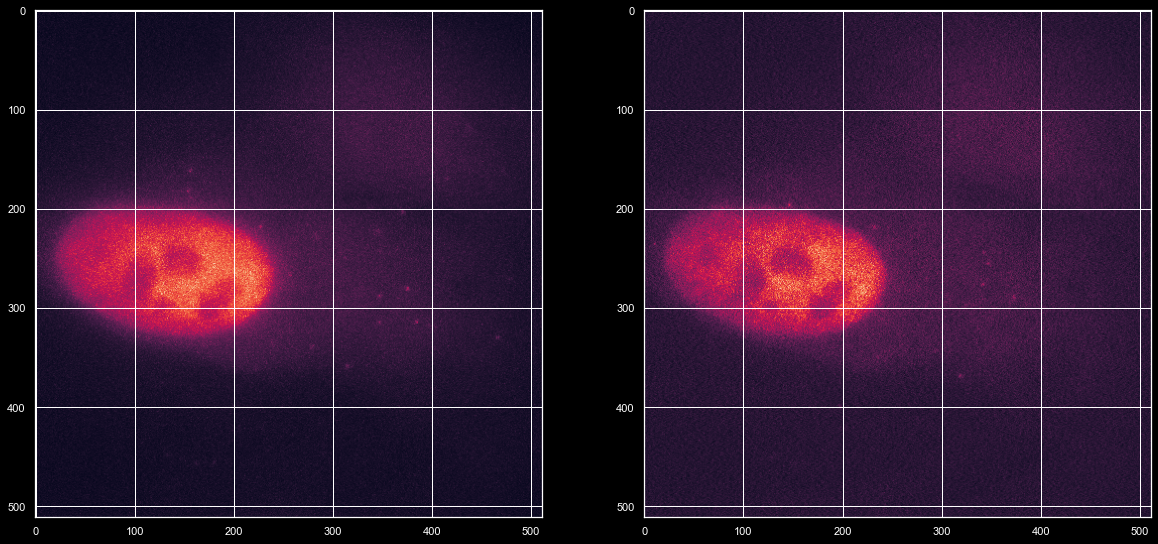

In [24]:
# plotting original image
# Just examining one of the images
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
ax[0].imshow(np.max(img_croparray[0,0,:,:,:,1], axis=0) )
ax[1].imshow(img_croparray[0,1,6,:,:,1])

## Spot detection and tracking


----

Just view video to determine what are the best z planes

In [264]:
viewer = napari.view_image(np.max(img_croparray[:,:,:,:,:,1],axis=1))

Now do max-projection on best-z planes

In [276]:
img_max = np.max(img_croparray[0,:,4:10,:,:,1],axis=1)
img_max.shape

(65, 512, 512)

Now you can create a mask to exclude regions, if desired

In [357]:
viewer = napari.view_image(np.max(img_max,axis=0))  # Max of max, should be a single frame

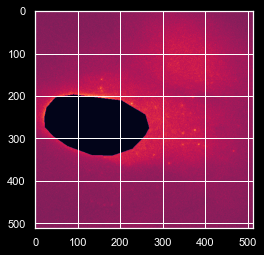

In [359]:
from matplotlib.path import Path
import pylab as plt
width, height=512,512

polygon=viewer.layers['Shapes'].data[0]
poly_path=Path(polygon)

x, y = np.mgrid[:height, :width]
coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1))) # coors.shape is (4000000,2)

mask = poly_path.contains_points(coors)
mask = mask.reshape(height, width)
mask2 = np.logical_not(mask)
plt.imshow(mask2*img_max[0])
plt.show()

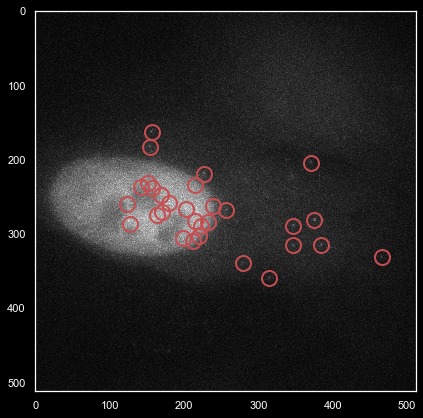

In [388]:
# Finding good settings
selected_channel = 0
particle_diameter=7
plt.figure(figsize=(7, 7))
f = tp.locate(img_max[0], particle_diameter,minmass=1000)
plt.grid(False)
tp.annotate(f, img_max[0]);

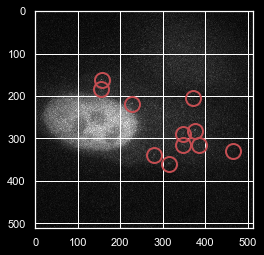

In [389]:
polygonxy=np.transpose([polygon[:,1],polygon[:,0]]) # Napari has x and y swapped compared to trackpy
poly = Polygon(polygonxy)  # This is a polygon that defines the mask
mypts = np.transpose([f.x,f.y]) # These are the points detected by trackpy
f['In Mask']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
tp.annotate(f[f['In Mask']==False], img_max[0]);

In [391]:
f = tp.batch(img_max, diameter=particle_diameter,minmass=1000)
f.to_csv(os.path.join(dir,img_4D_filename[:-4]+'.csv'))
f.head()

Frame 64: 20 features


,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,162.314288,156.047885,1578.220411,1.529673,0.131884,176.624047,28994.0,0.054826,0
1,182.776411,153.842445,1444.273882,1.508030,0.109588,172.805192,31053.0,0.045938,0
2,204.002477,370.318794,1458.370542,1.573965,0.036774,147.042052,27266.0,0.065455,0
3,218.808402,226.898315,1834.273406,1.413531,0.155329,232.748293,34293.0,0.036601,0
4,231.234459,150.646147,1112.885300,1.781617,0.218430,103.060634,56583.0,0.015261,0


In [392]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,162.314288,156.047885,1578.220411,1.529673,0.131884,176.624047,28994.0,0.054826,0
1,182.776411,153.842445,1444.273882,1.508030,0.109588,172.805192,31053.0,0.045938,0
2,204.002477,370.318794,1458.370542,1.573965,0.036774,147.042052,27266.0,0.065455,0
3,218.808402,226.898315,1834.273406,1.413531,0.155329,232.748293,34293.0,0.036601,0
4,231.234459,150.646147,1112.885300,1.781617,0.218430,103.060634,56583.0,0.015261,0
...,...,...,...,...,...,...,...,...,...
1576,315.323754,277.645780,2523.266035,1.458111,0.138921,307.396064,33674.0,0.037619,64
1577,343.883454,266.205445,2563.661782,1.506490,0.109865,284.121134,34931.0,0.034808,64
1578,349.081788,354.329591,1277.320846,1.534719,0.110253,151.863994,28081.0,0.058718,64
1579,370.930712,257.361687,1187.420138,1.520906,0.088614,146.685533,28488.0,0.056415,64


In [393]:
f_list = []
for i in f.frame:
    f0 = f[f['frame']==i]
    f1 = f0.copy()
    polygonxy=np.transpose([polygon[:,1],polygon[:,0]]) # Napari has x and y swapped compared to trackpy
    poly = Polygon(polygonxy)  # This is a polygon that defines the mask
    mypts = np.transpose([f1.x,f1.y]) # These are the points detected by trackpy
    f1['In Mask']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
    f_list.append(f1)
f_all = pd.concat(f_list)

In [401]:
f0 = f[f['frame']==0]
f1 = f0.copy()
polygonxy=np.transpose([polygon[:,1],polygon[:,0]]) # Napari has x and y swapped compared to trackpy
poly = Polygon(polygonxy)  # This is a polygon that defines the mask
mypts = np.transpose([f1.x,f1.y]) # These are the points detected by trackpy
f1['In Mask']=[poly.contains(Point(mypts[i])) for i in np.arange(len(mypts))] # Check if pts are on/in polygon mask  
f_list.append(f1)

In [402]:
f1

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,In Mask
0,162.314288,156.047885,1578.220411,1.529673,0.131884,176.624047,28994.0,0.054826,0,False
1,182.776411,153.842445,1444.273882,1.508030,0.109588,172.805192,31053.0,0.045938,0,False
2,204.002477,370.318794,1458.370542,1.573965,0.036774,147.042052,27266.0,0.065455,0,False
3,218.808402,226.898315,1834.273406,1.413531,0.155329,232.748293,34293.0,0.036601,0,False
4,231.234459,150.646147,1112.885300,1.781617,0.218430,103.060634,56583.0,0.015261,0,True
5,233.899015,214.843366,1252.285606,1.671224,0.150588,126.300746,53016.0,0.016831,0,True
6,236.922367,142.138577,1075.855327,1.560738,0.344726,115.054098,53334.0,0.016678,0,True
7,238.597428,156.120443,1102.127110,1.630066,0.138614,113.600834,55074.0,0.015888,0,True
8,247.649565,169.431637,1011.564546,1.472782,0.172812,162.030855,59487.0,0.014183,0,True
9,260.013026,123.403149,1023.017073,1.600779,0.141732,103.827634,54851.0,0.015985,0,True


Convert f to crop_array format

In [35]:
#only if you didn't track:
spots = f.copy() # Nice to copy; seems it can cause to overwrite otherwise
spots['id']=spots.index
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp'}, 
inplace=True, errors='raise')
spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

,fov,id,f,yc,xc,signal_tp
0,0,0,0,162.259624,156.115785,215.620736
1,0,1,0,182.465874,154.009988,205.804345
2,0,2,0,204.141354,370.350352,182.043080
3,0,3,0,218.884886,226.885067,276.748265
4,0,4,0,281.289698,375.116379,327.554589


## Create Crop Array
____

Create a crop array from 4D movie

In [36]:
my_ca = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])
my_ca

Original video dimensions:  (1, 65, 13, 512, 512, 3)
Padded video dimensions:  (1, 65, 13, 524, 524, 3)
Max # of spots per frame:  21
Shape of numpy array to hold all crop intensity data:  (1, 21, 65, 13, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 21, 65, 3)
Shape of extra my_layers numpy array:  (2, 1, 21, 65)


<xarray.Dataset>
Dimensions:    (fov: 1, n: 21, t: 65, z: 13, y: 11, x: 11, ch: 3)
Coordinates:
  * fov        (fov) int32 0
  * n          (n) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20
  * t          (t) int32 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x          (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch         (ch) int32 0 1 2
Data variables:
    int        (fov, n, t, z, y, x, ch) int32 771 516 520 856 500 ... 0 0 0 0 0
    xc         (fov, n, t, ch) int32 162 162 162 361 361 361 186 ... 0 0 0 0 0 0
    yc         (fov, n, t, ch) int32 168 168 168 216 216 216 189 ... 0 0 0 0 0 0
    dx         int32 1
    dy         int32 1
    dz         int32 500
    dt         int32 1
    xy_pad     int32 5
    id         (fov, n, t) float64 0.0 12.0 22.0 35.0 46.0 ... 0.0 0.0 0.0 0.0
    signal_tp  (fov, n, t) float64 216.0 156.0 182.0 302.0 ... 0.0 0.0 0.0 0.0
Attributes:
    name:     video_filename
    date:     video_date

## Quantify signal intensity through time
____

In [37]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca, ref_ch=1, disk_r=3, roll_n=3)

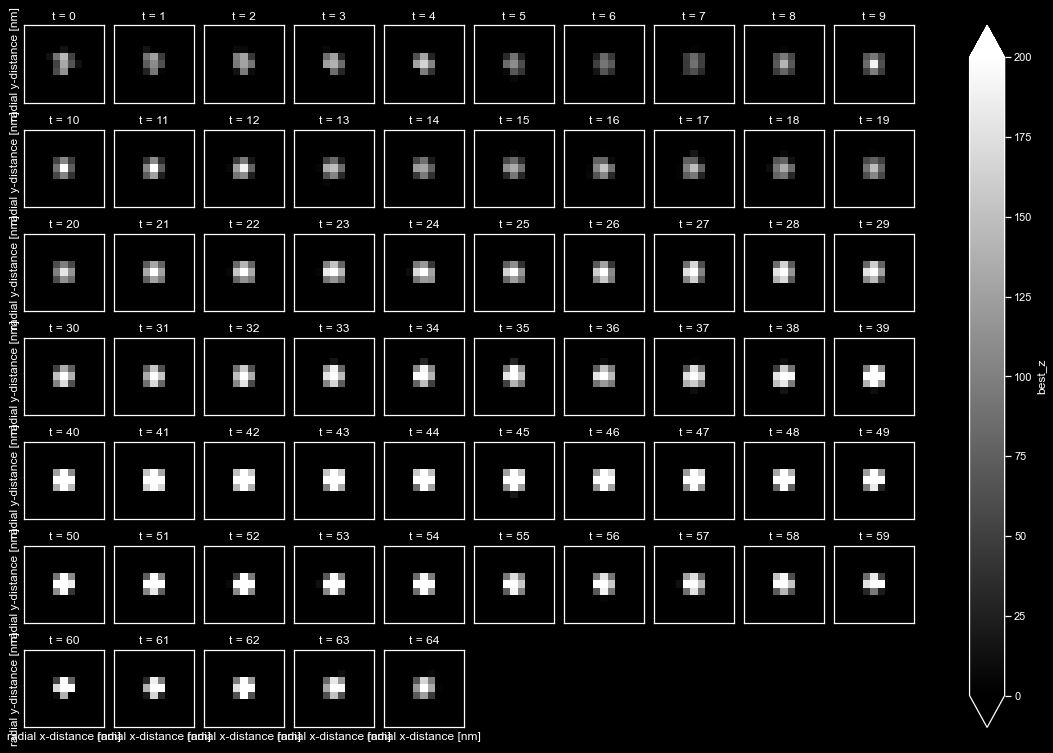

In [349]:
my_ca.best_z.mean('n').sel(fov=0,ch=1).rolling(t=3,min_periods=1).mean().plot.imshow(col='t',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,cmap='gray', vmin=0, vmax =200)

Let's compare our disk-donut 'signal' layer (acquired from 3D image) to trackpy's (acquired from max-projection):

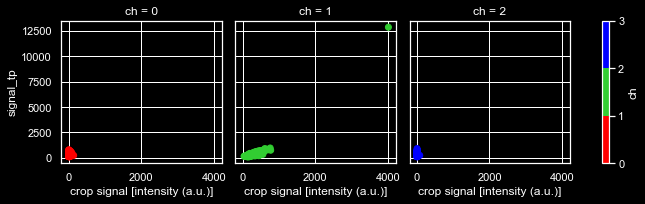

In [41]:
# Let's compare our intensity numbers to those from trackpy:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='signal_tp',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

Let's look at average signal vs time

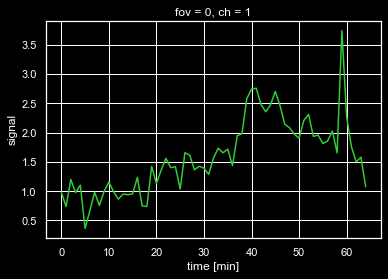

In [42]:
# Let's look at average signal vs time
start_sig = my_ca.signal.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0,ch=1).plot.line(x='t',hue='ch')

Now let's just use trackpy's values:

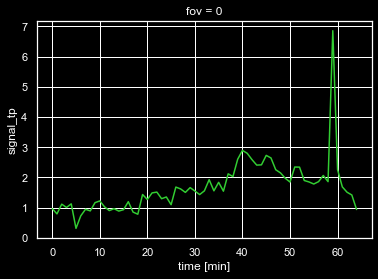

In [43]:
# Let's look at average signal vs time
start_sig = my_ca.signal_tp.mean('n').sel(t=slice(0,4)).mean('t')
end_sig = 0# my_ca.signal_tp.mean('n').sel(t=slice(15,20)).mean('t')
norm_sig = (my_ca.signal_tp.mean('n') - end_sig)/(start_sig - end_sig)
sns.set_palette(['limegreen','limegreen','blue'])
norm_sig.sel(fov=0).plot.line(x='t',hue='ch')

I guess trackpy and the disk donut method do a very good job at getting the intensities of spots. Although note that trackpy got the values from the max-intensity projection. Interesting.

## Visualize crop array montage with Napari
___

Now let's see a montage of the selected spots' best-z planes:

In [63]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_ca.sel(fov=0,ch=0).best_z,row='n',col='t'),contrast_limits=[60,800])

## Save the crop array
____

In [45]:
my_ca.to_netcdf(os.path.join(dir,img_4D_filename[:-4]+'.nc') )

## Optional: Create Track Array
___

In [ ]:
# Read in the csv file

In [116]:
# Note, if you actually wanted to track, you could use the following:
# link tracks
max_distance_movement = 15
track_skip_frames = 3
min_trajectory_length = 10
t = tp.link(f, max_distance_movement, memory=track_skip_frames)
t1 = tp.filter_stubs(t, min_trajectory_length)
t1['particle'] = t1['particle']+1 # VERY IMPORTANT NOT TO HAVE TRACK IDs WITH VALUES = 0 WHEN MAKING CROP ARRAYS AS ZERO IS DEFAULT EMPTY VALUE
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique()) 

Frame 64: 8 trajectories present.
Before: 263
After: 17


In [117]:
# only if you tracked:
spots = t1.copy()
spots.rename(columns={'x': 'xc','y': 'yc', 'frame': 'f','signal':'signal_tp','particle':'id'}, 
inplace=True, errors='raise')


spots['fov']=0
spots.rename(columns={'particle':'id'})
spots = spots[['fov','id','f','yc','xc','signal_tp']] # keeping signal out of curiousity... want to compare to disk-donut measurements  
spots.head()

,fov,id,f,yc,xc,signal_tp
frame,,,,,,
0,0,2,0,359.443039,314.358883,179.643962
1,0,2,1,369.247433,318.545680,275.664793
2,0,2,2,369.620758,316.715387,278.912957
2,0,19,2,344.798019,276.392962,317.330612
2,0,20,2,271.377158,324.952399,225.799361


In [118]:
my_ca2 = ca.create_crop_array(img_croparray,spots,xy_pad=particle_diameter//2+1, dxy=130, dz=500, dt=1, units=['nm','min'])

Original video dimensions:  (1, 65, 13, 512, 512, 3)
Padded video dimensions:  (1, 65, 13, 524, 524, 3)
Max # of spots per frame:  9
Shape of numpy array to hold all crop intensity data:  (1, 9, 65, 13, 11, 11, 3)
Shape of xc and yc numpy arrays:  (1, 9, 65, 3)
Shape of extra my_layers numpy array:  (2, 1, 9, 65)


In [119]:
# Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer
ca.measure_signal(my_ca2, ref_ch=1, disk_r=3, roll_n=3)

In [120]:
import xarray as xr
import pandas as pd
# Since ids correspond to tracks, we can organize tracks in rows  
my_ids = np.unique(my_ca2.id) # Find all unique ids
my_ids = my_ids[1:] # remove the '0' ID used as filler in Crop Arrays
my_ids
# Get a list of xarrays for each unique id 
my_das = []
for i in np.arange(len(my_ids)):
    temp = my_ca2.groupby('id')[my_ids[i]].reset_index('stacked_fov_n_t').reset_coords('n',drop=True).reset_coords('fov',drop=True).swap_dims({'stacked_fov_n_t':'t'})
    my_das.append(temp)
    del temp
# Concatenate the xarrays together to make a new xarray dataset in a track array format (each track on separate row). Here 'n' is replaced by 'tracks'
my_taz = xr.concat(my_das, dim=pd.Index(my_ids, name='track_id'), fill_value=255) # fill_value=0 so keep int instead of moving to floats with NaNs
my_taz = my_taz.transpose('track_id','fov','n','t','z','y','x','ch', missing_dims='ignore') # reorder for napari
my_taz

<xarray.Dataset>
Dimensions:    (t: 65, z: 13, y: 11, x: 11, ch: 3, track_id: 17)
Coordinates:
  * t          (t) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x          (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch         (ch) int64 0 1 2
  * track_id   (track_id) float64 2.0 19.0 20.0 52.0 ... 210.0 217.0 221.0 230.0
Data variables: (12/13)
    int        (track_id, t, z, y, x, ch) int32 805 602 488 717 ... 255 255 255
    xc         (track_id, t, ch) int32 320 320 320 325 325 ... 266 255 255 255
    yc         (track_id, t, ch) int32 365 365 365 375 375 ... 309 255 255 255
    dx         (track_id) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    dy         (track_id) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    dz         (track_id) int32 500 500 500 500 500 500 ... 500 500 500 500 500
    ...         ...
    xy_pad     (track_id) int32 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
    id         (track_id, t) float64 2.0 2.0 2.0 2.0 ... 230.0 230.0 230.0 255.0
    signal_tp  (track_id, t) float64 180.0 276.0 279.0 ... 217.0 252.0 255.0
    zc         (track_id, t) int64 5 6 6 6 6 255 6 6 6 ... 2 3 255 3 3 3 3 3 255
    best_z     (track_id, t, y, x, ch) float64 40.1 -169.7 ... 255.0 255.0
    signal     (track_id, t, ch) float64 -7.578 162.7 -3.816 ... 255.0 255.0
Attributes:
    name:     video_filename
    date:     video_date

In [121]:
# view the action of montage showing an n x n crop_array through time
viewer = napari.view_image(ca.montage(my_taz.sel(ch=1).best_z,row='track_id',col='t'),contrast_limits=[60,800])

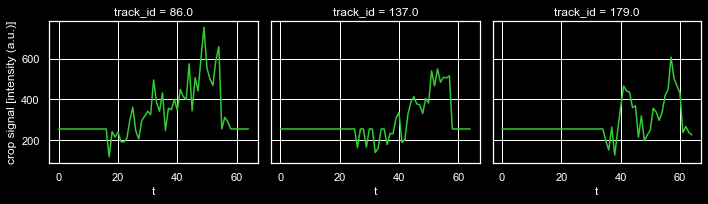

In [122]:
my_taz.isel(track_id=[5,6,9]).sel(ch=1).signal.plot.line(x='t',col='track_id',col_wrap=3)

In [123]:
my_taz.isel(track_id=[5,6,9])

<xarray.Dataset>
Dimensions:    (t: 65, z: 13, y: 11, x: 11, ch: 3, track_id: 3)
Coordinates:
  * t          (t) int64 0 1 2 3 4 5 6 7 8 9 ... 55 56 57 58 59 60 61 62 63 64
  * z          (z) int32 0 500 1000 1500 2000 2500 ... 4000 4500 5000 5500 6000
  * y          (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x          (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch         (ch) int64 0 1 2
  * track_id   (track_id) float64 86.0 137.0 179.0
Data variables: (12/13)
    int        (track_id, t, z, y, x, ch) int32 255 255 255 255 ... 703 627 499
    xc         (track_id, t, ch) int32 255 255 255 255 255 ... 314 307 307 307
    yc         (track_id, t, ch) int32 255 255 255 255 255 ... 290 290 290 290
    dx         (track_id) int32 1 1 1
    dy         (track_id) int32 1 1 1
    dz         (track_id) int32 500 500 500
    ...         ...
    xy_pad     (track_id) int32 5 5 5
    id         (track_id, t) float64 255.0 255.0 255.0 ... 179.0 179.0 179.0
    signal_tp  (track_id, t) float64 255.0 255.0 255.0 ... 376.0 331.0 250.0
    zc         (track_id, t) int64 255 255 255 255 255 255 255 ... 5 5 5 3 5 3 4
    best_z     (track_id, t, y, x, ch) float64 255.0 255.0 ... -182.3 -26.52
    signal     (track_id, t, ch) float64 255.0 255.0 255.0 ... 49.99 225.7 22.42
Attributes:
    name:     video_filename
    date:     video_date

In [52]:
my_taz.isel(track_id=[1,3,6,8,17,19]).sel(ch=1).signal.plot.line(x='t',col='track_id',col_wrap=3)

IndexError: index 17 is out of bounds for axis 0 with size 17

# Trying to track in x, y, and z:

Measure signals and plot average signal through time, creating 'best_z' layer and 'signal' layer

In [ ]:
max_distance_movement = 5
track_skip_frames = 3
my_frame = 15
min_trajectory_length=2
my_list = []
for my_frame in np.arange(len(img_croparray[0,:])): #np.arange(15,16,1):
    f = tp.batch(img_croparray[0,my_frame,:,:,:,1], diameter=7,minmass=1000)
    t1 = tp.link(f, max_distance_movement, memory=track_skip_frames)
    t = tp.filter_stubs(t1, min_trajectory_length)
    sort_t = t.sort_values(['particle']).groupby('particle').aggregate('max').reset_index().rename(columns={'frame':'z'})
    sort_t['t']=my_frame
    my_list.append(sort_t)
my_df = pd.concat(my_list)
my_df.reset_index()

Frame 12: 6 trajectories present.


,index,particle,y,x,mass,size,ecc,signal,raw_mass,ep,z,t
0,0,1,265.126123,179.288674,1628.551584,1.874931,0.456239,223.443949,57427.0,0.018648,7,0
1,1,3,267.046963,205.697036,1414.572406,1.854444,0.323982,172.348805,57278.0,0.020035,11,0
2,2,7,296.339594,146.190013,1404.200152,1.798229,0.419493,162.043243,54490.0,0.016932,6,0
3,3,8,286.356175,214.849965,1466.282876,1.802885,0.275980,148.216038,57679.0,0.020939,8,0
4,4,9,282.030380,129.168233,1497.468179,1.852901,0.297139,196.285890,55725.0,0.021990,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4588,44,110,308.218702,376.070087,4494.276641,1.868788,0.221681,509.585766,35307.0,0.054544,11,64
4589,45,112,374.020162,257.493160,1620.912914,1.624109,0.148189,192.307055,25918.0,0.062328,10,64
4590,46,118,277.154825,202.980465,1130.622733,1.828707,0.432607,172.092273,38823.0,0.028547,11,64
4591,47,122,232.825651,99.334905,1151.751786,1.730539,0.409167,163.599224,36874.0,0.031245,11,64


<AxesSubplot:>

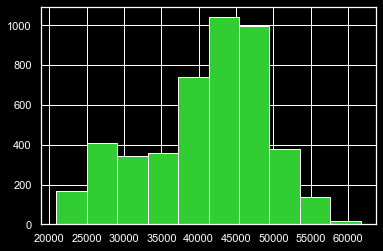

In [ ]:
my_df['raw_mass'].hist()

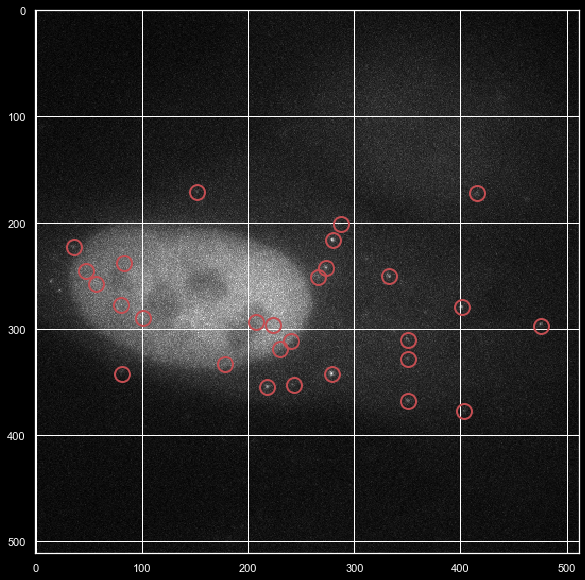

In [ ]:
plt.figure(figsize=(20,10))
tp.annotate(my_df[(my_df['t']==28)&(my_df['raw_mass']<40000)], img_4D_max_real[28]);

In [ ]:
np.array([len(t[t['particle']==i].x) for i in np.arange(len(t.particle))])

array([1, 1, 1, 1, 1, 1, 2, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1,
       2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
f[f['frame']==6]

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
21,199.941265,158.826173,2982.658604,1.808923,0.151357,256.737700,49999.0,0.091167,6
22,249.929065,118.917865,2305.135120,2.359763,0.318766,129.044630,74325.0,0.042423,6
23,261.733050,196.617776,2588.939285,2.108862,0.372685,188.987310,85949.0,0.033790,6
24,263.533709,182.078865,2290.839921,2.036925,0.209254,172.596213,79837.0,0.037839,6
25,272.166431,48.646168,2393.582012,2.066912,0.211147,190.519079,60782.0,0.060403,6
26,277.176334,245.423301,2795.418528,2.373916,0.112889,156.154188,76473.0,0.040510,6
27,288.243814,47.695592,2441.815087,2.412482,0.269415,112.112909,55096.0,0.073477,6
28,297.305687,242.746424,2219.316915,2.253066,0.334894,141.937341,63311.0,0.055973,6
29,306.568386,206.760561,2360.231771,2.127487,0.201236,150.669596,75359.0,0.041480,6
30,324.411775,83.082963,2807.539478,1.904394,0.173743,222.839000,41557.0,0.151626,6
